In [2]:
# We need to install the very latest versions from GitHub
# This command also upgrades torch, torchvision, and peft to compatible versions
!pip install -q git+https://github.com/huggingface/diffusers \
  accelerate transformers ftfy bitsandbytes xformers \
  torch torchvision peft --upgrade

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import os

# --- 1. Dataset Configuration ---
# TODO: Change this to the full path of your dataset's main folder
# This is the folder that contains your 20 subfolders.
# Example: '/kaggle/input/my-image-dataset/main_folder_with_20_subfolders'
DATA_DIR = '/kaggle/input/adavu-keyposture-20-classes/data_20_image'


# --- 2. Model Configuration ---
# We will use Stable Diffusion 1.5 as the base
BASE_MODEL = "runwayml/stable-diffusion-v1-5"


# --- 3. Output Configuration ---
# This is where your final trained LoRA model will be saved
OUTPUT_LORA_NAME = "my_lora_model"

# This is a temporary directory to prepare your dataset
TRAIN_DATA_DIR = "/kaggle/working/my_training_dataset"


# --- (No need to edit below this line) ---
# Create the paths
LORA_OUTPUT_PATH = f"/kaggle/working/{OUTPUT_LORA_NAME}"
METADATA_FILE = os.path.join(TRAIN_DATA_DIR, 'metadata.jsonl')

print("Configuration set:")
print(f"  Base Model: {BASE_MODEL}")
print(f"  Dataset Path: {DATA_DIR}")
print(f"  LoRA Output Path: {LORA_OUTPUT_PATH}")

Configuration set:
  Base Model: runwayml/stable-diffusion-v1-5
  Dataset Path: /kaggle/input/adavu-keyposture-20-classes/data_20_image
  LoRA Output Path: /kaggle/working/my_lora_model


In [4]:
import json
import os
from collections import defaultdict

# Make the directories
os.makedirs(TRAIN_DATA_DIR, exist_ok=True)

print(f"Scanning images in {DATA_DIR} to determine minimum count...")

image_counts = defaultdict(int)
min_images_per_folder = float('inf') # Start with infinity

# --- First Pass: Count images and find minimum ---
for folder_name in os.listdir(DATA_DIR):
    folder_path = os.path.join(DATA_DIR, folder_name)
    if not os.path.isdir(folder_path):
        continue

    # Count valid image files in the folder
    count = 0
    for f in os.listdir(folder_path):
        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
            count += 1

    if count > 0: # Only consider folders with images
        image_counts[folder_name] = count
        min_images_per_folder = min(min_images_per_folder, count)
    else:
        print(f"  Warning: Folder '{folder_name}' has no images, skipping.")

if min_images_per_folder == float('inf'):
     raise ValueError("No valid image folders found or all folders are empty.")

print(f"Minimum images found in a folder: {min_images_per_folder}")
print(f"Will use {min_images_per_folder} images from each valid folder.")
print(f"Saving balanced metadata to {METADATA_FILE}...")


# --- Second Pass: Create metadata using the minimum count ---
with open(METADATA_FILE, 'w') as f_meta:
    # Iterate through your 20 folders (or however many valid ones were found)
    for folder_name in image_counts.keys(): # Only use folders that had images
        folder_path = os.path.join(DATA_DIR, folder_name)

        # This will be our text prompt. We clean up the name.
        prompt = f"a photo of a {folder_name.replace('_', ' ')}"

        # Get image files, sort them to be consistent (optional but good practice)
        image_files = sorted([
            f for f in os.listdir(folder_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))
        ])

        # --- IMPORTANT: Select only the minimum number of images ---
        selected_image_files = image_files[:min_images_per_folder]

        for image_name in selected_image_files:
            image_path = os.path.join(folder_path, image_name)

            # Create the metadata entry
            metadata_entry = {
                "file_name": image_path,
                "text": prompt
            }
            f_meta.write(json.dumps(metadata_entry) + '\n')

print(f"✅ Balanced dataset preparation complete! Using {min_images_per_folder} images per class.")

Scanning images in /kaggle/input/adavu-keyposture-20-classes/data_20_image to determine minimum count...
Minimum images found in a folder: 199
Will use 199 images from each valid folder.
Saving balanced metadata to /kaggle/working/my_training_dataset/metadata.jsonl...
✅ Balanced dataset preparation complete! Using 199 images per class.


In [5]:
# Go to the /kaggle/working/ directory
%cd /kaggle/working/

# 1. Force-delete the old 'diffusers' folder
print("Deleting old scripts...")
!rm -rf diffusers

# 2. Force-delete the bad dataset cache
print("Clearing Hugging Face dataset cache...")
!rm -rf ~/.cache/huggingface/datasets

# 3. Clone the fresh, up-to-date scripts from GitHub
print("Cloning new scripts...")
!git clone https://github.com/huggingface/diffusers

# 4. Move into the correct folder to run the script
%cd /kaggle/working/diffusers/examples/text_to_image
print("Ready to train.")

/kaggle/working
Deleting old scripts...
Clearing Hugging Face dataset cache...
Cloning new scripts...
Cloning into 'diffusers'...
remote: Enumerating objects: 109497, done.
remote: Counting objects: 100% (690/690), done.
remote: Compressing objects: 100% (295/295), done.
remote: Total 109497 (delta 558), reused 397 (delta 395), pack-reused 108807 (from 4)
Receiving objects: 100% (109497/109497), 84.43 MiB | 32.35 MiB/s, done.
Resolving deltas: 100% (81139/81139), done.
/kaggle/working/diffusers/examples/text_to_image
Ready to train.


In [6]:
# --- !! PATCH SCRIPT (v2) !! ---
# This cell fixes the training script by:
# 1. Adding `from PIL import Image` at the top.
# 2. Fixing the broken data-loading line.

print("Patching train_text_to_image_lora.py...")

# Define the file to patch
SCRIPT_PATH = "/kaggle/working/diffusers/examples/text_to_image/train_text_to_image_lora.py"

# --- Fix 1: Add the missing import ---
IMPORT_LINE = "from PIL import Image\n"
# We will add this import near the other 'import' statements
ANCHOR_LINE = "import diffusers"

# --- Fix 2: The original bug ---
BUGGY_LINE = 'images = [image.convert("RGB") for image in examples[image_column]]'
FIXED_LINE = 'images = [Image.open(image).convert("RGB") for image in examples[image_column]]'

# Read the script
with open(SCRIPT_PATH, 'r') as f:
    script_contents = f.read()

# Apply Fix 1 (Add import)
if IMPORT_LINE not in script_contents:
    script_contents = script_contents.replace(ANCHOR_LINE, f"{ANCHOR_LINE}\n{IMPORT_LINE}")
    print("Added missing 'from PIL import Image' import.")
else:
    print("Import 'from PIL import Image' already present.")
    
# Apply Fix 2 (Fix data loading)
if BUGGY_LINE in script_contents:
    script_contents = script_contents.replace(BUGGY_LINE, FIXED_LINE)
    print("Fixed data loading line.")
else:
    print("Data loading line already fixed.")

# Write the patched script back
with open(SCRIPT_PATH, 'w') as f:
    f.write(script_contents)

print("✅ Patch applied successfully!")

Patching train_text_to_image_lora.py...
Added missing 'from PIL import Image' import.
Fixed data loading line.
✅ Patch applied successfully!


In [ ]:
!mv /kaggle/working/my_lora_model /kaggle/working/my_lora_model_old


In [7]:
# TODO: Before you run, update the validation_prompt!
# Replace '[YOUR_FOLDER_NAME_HERE]' with one of your actual folder names
# (e.g., "a photo of a 100")
# This lets the model save a sample image during training.

# TODO: Adjust max_train_steps as needed.
# Increased significantly to aim for overfitting/perfection.
# Training will take MUCH longer. Start with 20000, increase if needed.
# Keep checkpointing_steps relatively frequent (e.g., 1000 or 2000)
# to save intermediate progress.

# NOTE: Set --resolution to 128 as requested.

# NOTE: Removed --resume_from_checkpoint. Add it back if you need to resume.
# If resuming, ensure the previous checkpoint was also trained at 128 resolution.

!accelerate launch --mixed_precision="no" train_text_to_image_lora.py \
  --pretrained_model_name_or_path=$BASE_MODEL \
  --dataset_name=$TRAIN_DATA_DIR \
  --image_column="file_name" \
  --caption_column="text" \
  --dataloader_num_workers=8 \
  --resolution=128 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=10000 \
  --learning_rate=1e-04 \
  --max_grad_norm=1 \
  --lr_scheduler="cosine" --lr_warmup_steps=0 \
  --output_dir=$LORA_OUTPUT_PATH \
  --report_to="tensorboard" \
  --validation_prompt="a photo of a 100" \
  --seed=1337 \
  --enable_xformers_memory_efficient_attention \
  --checkpointing_steps=5000

print(f" Training finished! Model saved to: {LORA_OUTPUT_PATH}")

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
# We must re-install the libraries in our new session
# !pip install -q git+https://github.com/huggingface/diffusers \
#   accelerate transformers ftfy bitsandbytes xformers \
#   torch torchvision peft --upgrade

# Import the libraries
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from PIL import Image
import os

# Move to the main working directory
%cd /kaggle/working/

RuntimeError: Failed to import diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion because of the following error (look up to see its traceback):
Could not import module 'CLIPImageProcessor'. Are this object's requirements defined correctly?

In [1]:
# Import all the necessary libraries
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from PIL import Image
import os

# --- 1. Define Model Paths ---
BASE_MODEL = "runwayml/stable-diffusion-v1-5"
# This path points to your checkpoint in the temporary working directory
LORA_PATH = "/kaggle/working/my_lora_model_old/checkpoint-5000" 

print(f"Loading base model: {BASE_MODEL}")
print(f"Loading LoRA from: {LORA_PATH}") 

# --- 2. Load the Base Pipeline ---
pipe = StableDiffusionPipeline.from_pretrained(
    BASE_MODEL, 
    torch_dtype=torch.float16
)
# This line is now fixed because DPMSolverMultstepScheduler is imported
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config) 

# --- 3. Load and Attach Your LoRA Weights ---
pipe.unet.load_attn_procs(LORA_PATH)
pipe.to("cuda")

print(" Model and checkpoint-5000 LoRA weights loaded successfully!")

2025-10-26 19:45:35.795267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761507936.010107      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761507936.074610      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading base model: runwayml/stable-diffusion-v1-5
Loading LoRA from: /kaggle/working/my_lora_model_old/checkpoint-5000


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/loaders/unet.py:209: FutureWarning: `load_attn_procs` is deprecated and will be removed in version 0.40.0. Using the `load_attn_procs()` method has been deprecated and will be removed in a future version. Please use `load_lora_adapter()`.
  deprecate("load_attn_procs", "0.40.0", deprecation_message)


 Model and checkpoint-5000 LoRA weights loaded successfully!


In [3]:
!pip install lpips torch torchvision pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nv

In [2]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:010:02m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:010:02m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nv

In [4]:
import lpips
import torch
from PIL import Image
from torchvision.transforms import ToTensor, Normalize, Compose, Resize
import os

def load_and_preprocess_image(image_path):
    """Loads an image, converts to RGB, and preprocesses it for LPIPS."""
    # LPIPS models expect tensors in the range [-1, 1]
    # 1. Resize to a common size (optional, but good practice)
    # 2. Convert to Tensor (scales to [0, 1])
    # 3. Normalize (maps [0, 1] to [-1, 1])
    transform = Compose([
        Resize((256, 256)),  
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0) # Add batch dimension

# --- List of folder names ---
FOLDER_NAMES = [
    "100", "103", "11", "153", "27", "3", "44", "45", "46", "47",
    "48", "49", "5", "59", "60", "77", "79", "8", "85", "87"
]

# --- Base paths ---
GENERATED_IMG_BASE_PATH = "/kaggle/working/generated_image_"
DATASET_BASE_PATH = "/kaggle/input/adavu-keyposture-20-classes/data_20_image"

# --- Main execution ---

# 1. Load the LPIPS model (using AlexNet, which is standard)
# We set .eval() as we are not training the model
print("Loading LPIPS model (AlexNet)...")
loss_fn_alex = lpips.LPIPS(net='alex').eval()
print("Model loaded.")

all_distances = []

print("\nStarting LPIPS calculation for 20 image pairs...")
print("-" * 50)

# 2. Loop through all folder names
for folder_name in FOLDER_NAMES:
    try:
        # --- Construct paths for the current pair ---
        
        # 1. Generated image path
        gen_img_path = f"{GENERATED_IMG_BASE_PATH}{folder_name}.png"
        
        # 2. Dataset image path
        dataset_folder_path = os.path.join(DATASET_BASE_PATH, folder_name)
        
        # Find the first image file in the dataset folder
        image_files = [f for f in os.listdir(dataset_folder_path) 
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if not image_files:
            print(f"Warning: No images found in {dataset_folder_path}. Skipping folder {folder_name}.")
            continue
            
        image_files.sort() # Sort alphabetically to get the "first" one
        first_dataset_image_name = image_files[0]
        dataset_img_path = os.path.join(dataset_folder_path, first_dataset_image_name)

        # --- Load and preprocess images ---
        img1_tensor = load_and_preprocess_image(gen_img_path)
        img2_tensor = load_and_preprocess_image(dataset_img_path)

        # --- Calculate the distance ---
        with torch.no_grad():
            distance = loss_fn_alex(img1_tensor, img2_tensor)
        
        distance_val = distance.item()
        all_distances.append(distance_val)
        
        print(f"Folder {folder_name:>3}: LPIPS = {distance_val:.4f}")
        # Uncomment the line below for more detailed logging
        # print(f"  Comparing: {gen_img_path}\n  With:      {dataset_img_path}")

    except FileNotFoundError as e:
        print(f"Error: File not found for folder {folder_name}. Details: {e}. Skipping.")
    except Exception as e:
        print(f"An unexpected error occurred for folder {folder_name}: {e}. Skipping.")

# --- 3. Calculate and print the average score ---

print("-" * 50)
if all_distances:
    average_score = sum(all_distances) / len(all_distances)
    print(f"\nCalculation Complete.")
    print(f"Total Images Processed: {len(all_distances)}")
    print(f"Average LPIPS Score:  {average_score:.4f}")
    print("Interpretation: Lower is better (more perceptually similar).")
else:
    print("\nNo LPIPS scores were calculated. Please check file paths and folder names.")

Loading LPIPS model (AlexNet)...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Model loaded.

Starting LPIPS calculation for 20 image pairs...
--------------------------------------------------
Folder 100: LPIPS = 0.6269
Folder 103: LPIPS = 0.5640
Folder  11: LPIPS = 0.4135
Folder 153: LPIPS = 0.6014
Folder  27: LPIPS = 0.5205
Folder   3: LPIPS = 0.4035
Folder  44: LPIPS = 0.6000
Folder  45: LPIPS = 0.6715
Folder  46: LPIPS = 0.5436
Folder  47: LPIPS = 0.6050
Folder  48: LPIPS = 0.5713
Folder  49: LPIPS = 0.5608
Folder   5: LPIPS = 0.6287
Folder  59: LPIPS = 0.5894
Folder  60: LPIPS = 0.6015
Folder  77: LPIPS = 0.5007
Folder  79: LPIPS = 0.4971
Folder   8: LPIPS = 0.4513
Folder  85: LPIPS = 0.5335
Folder  87: LPIPS = 0.5959
--------------------------------------------------

Calculation Complete.
Total Images Processed: 20
Average LPIPS Score:  0.5540
Interpretation: Lower 

In [3]:
!pip install mediapipe opencv-python-headless

INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 50.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 35.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 24.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.12.0.88
    Uninstalling opencv-contrib-python-4.12.0.88:
      Su

In [8]:
!wget -O pose_landmarker_full.task https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_full/float16/1/pose_landmarker_full.task

--2025-10-26 19:11:49--  https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_full/float16/1/pose_landmarker_full.task
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.207, 74.125.132.207, 192.178.210.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9398198 (9.0M) [application/octet-stream]
Saving to: ‘pose_landmarker_full.task’

pose_landmarker_ful 100%[===================>]   8.96M  --.-KB/s    in 0.07s   

2025-10-26 19:11:50 (129 MB/s) - ‘pose_landmarker_full.task’ saved [9398198/9398198]



In [16]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 48.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
!pip install mediapipe

  Using cached mediapipe-0.10.21-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
  Using cached protobuf-4.25.8-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
Using cached mediapipe-0.10.21-cp311-cp311-manylinux_2_28_x86_64.whl (35.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 64.0 MB/s eta 0:00:00:00:0100:01
Using cached protobuf-4.25.8-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is inco

In [10]:
from ultralytics import YOLO
import cv2

# download pretrained pose model
model = YOLO("yolov8n-pose.pt")

def process_and_draw_pose(image_path, out_name):
    img = cv2.imread(image_path)
    res = model(image_path)
    res[0].plot()              # draws skeleton on image automatically
    out = res[0].plot()
    cv2.imwrite(out_name, out)
    print("saved", out_name)

img1 = "/kaggle/working/generated_image.png"
img2 = "/kaggle/input/adavu-keyposture-20-classes/data_20_image/11/J3D1P11_326.png"

process_and_draw_pose(img1, "image1_with_pose.jpg")
process_and_draw_pose(img2, "image2_with_pose.jpg")




image 1/1 /kaggle/working/generated_image.png: 640x640 2 persons, 15.5ms
Speed: 4.6ms preprocess, 15.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
saved image1_with_pose.jpg

image 1/1 /kaggle/input/adavu-keyposture-20-classes/data_20_image/11/J3D1P11_326.png: 640x608 3 persons, 12.8ms
Speed: 2.9ms preprocess, 12.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 608)
saved image2_with_pose.jpg


In [17]:
!pip install "numpy<2.0"

Generating 20 images...

--- Generating for prompt: 'a photo of a 100' ---


  0%|          | 0/40 [00:00<?, ?it/s]

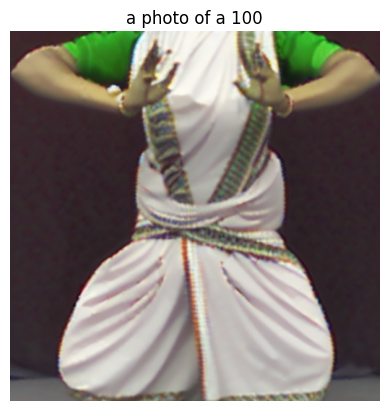

Saved image to: generated_image_100.png

--- Generating for prompt: 'a photo of a 103' ---


  0%|          | 0/40 [00:00<?, ?it/s]

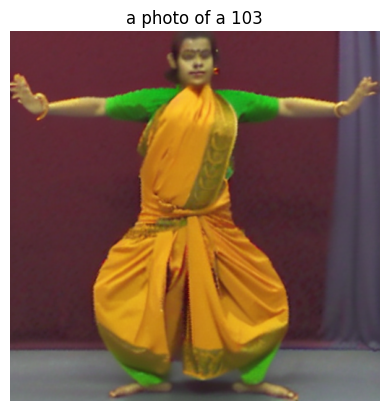

Saved image to: generated_image_103.png

--- Generating for prompt: 'a photo of a 11' ---


  0%|          | 0/40 [00:00<?, ?it/s]

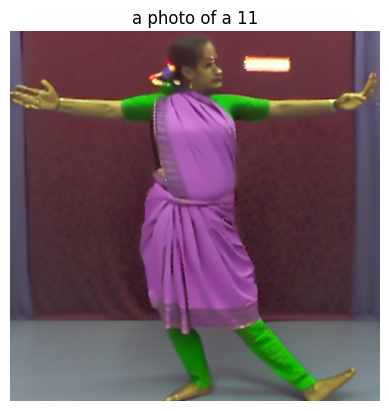

Saved image to: generated_image_11.png

--- Generating for prompt: 'a photo of a 153' ---


  0%|          | 0/40 [00:00<?, ?it/s]

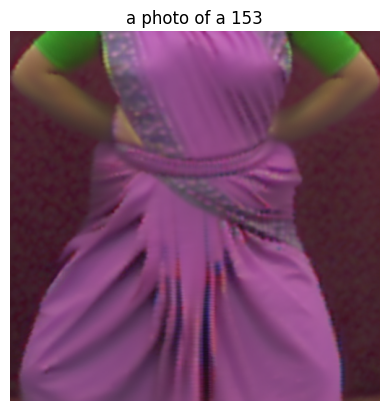

Saved image to: generated_image_153.png

--- Generating for prompt: 'a photo of a 27' ---


  0%|          | 0/40 [00:00<?, ?it/s]

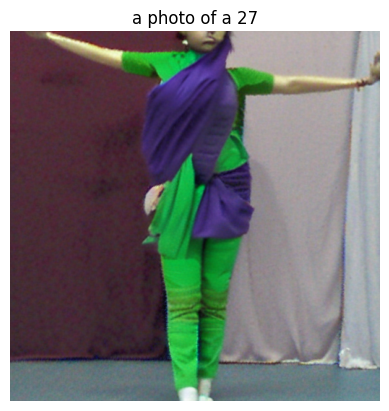

Saved image to: generated_image_27.png

--- Generating for prompt: 'a photo of a 3' ---


  0%|          | 0/40 [00:00<?, ?it/s]

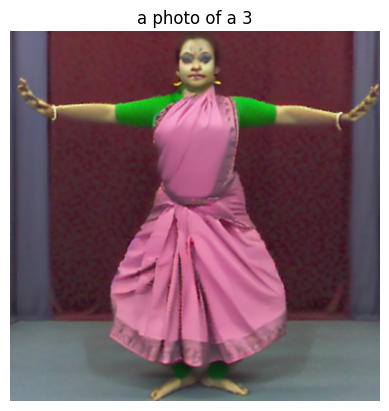

Saved image to: generated_image_3.png

--- Generating for prompt: 'a photo of a 44' ---


  0%|          | 0/40 [00:00<?, ?it/s]

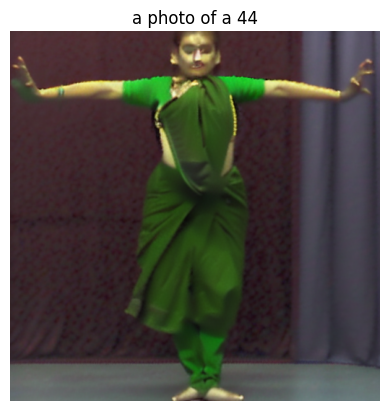

Saved image to: generated_image_44.png

--- Generating for prompt: 'a photo of a 45' ---


  0%|          | 0/40 [00:00<?, ?it/s]

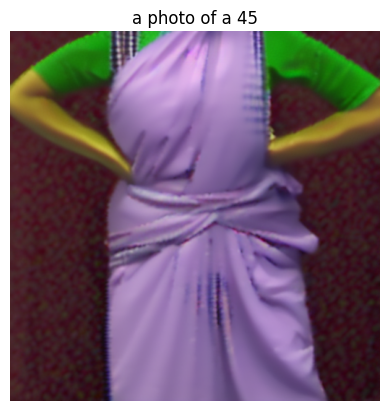

Saved image to: generated_image_45.png

--- Generating for prompt: 'a photo of a 46' ---


  0%|          | 0/40 [00:00<?, ?it/s]

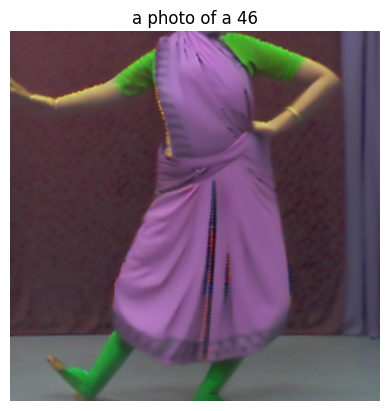

Saved image to: generated_image_46.png

--- Generating for prompt: 'a photo of a 47' ---


  0%|          | 0/40 [00:00<?, ?it/s]

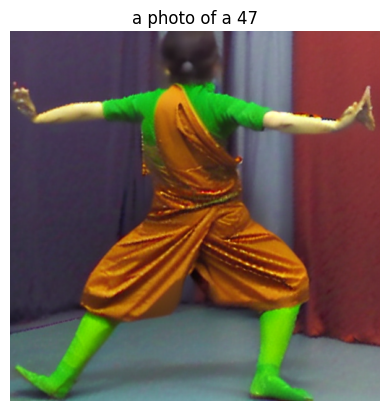

Saved image to: generated_image_47.png

--- Generating for prompt: 'a photo of a 48' ---


  0%|          | 0/40 [00:00<?, ?it/s]

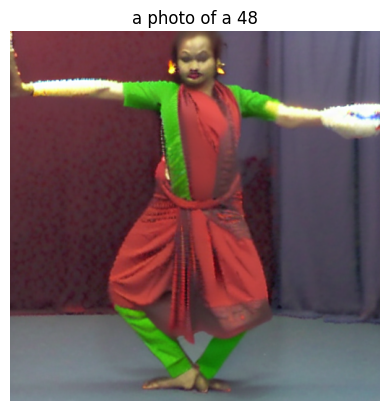

Saved image to: generated_image_48.png

--- Generating for prompt: 'a photo of a 49' ---


  0%|          | 0/40 [00:00<?, ?it/s]

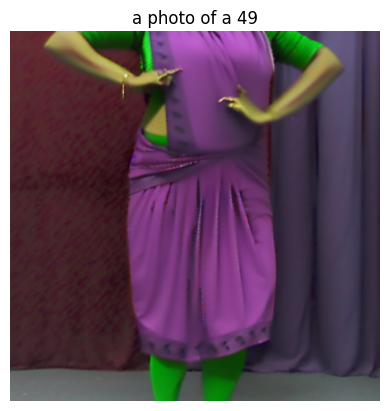

Saved image to: generated_image_49.png

--- Generating for prompt: 'a photo of a 5' ---


  0%|          | 0/40 [00:00<?, ?it/s]

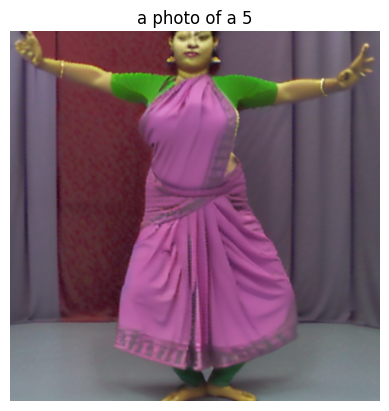

Saved image to: generated_image_5.png

--- Generating for prompt: 'a photo of a 59' ---


  0%|          | 0/40 [00:00<?, ?it/s]

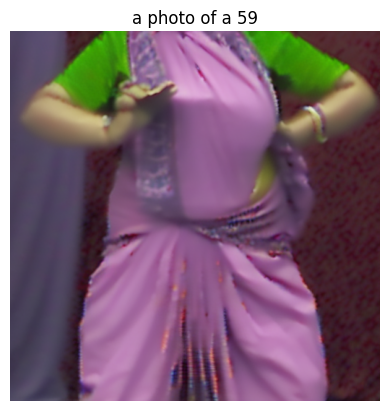

Saved image to: generated_image_59.png

--- Generating for prompt: 'a photo of a 60' ---


  0%|          | 0/40 [00:00<?, ?it/s]

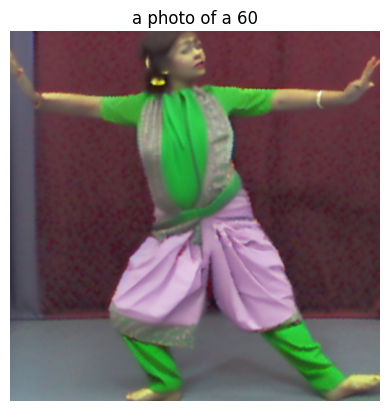

Saved image to: generated_image_60.png

--- Generating for prompt: 'a photo of a 77' ---


  0%|          | 0/40 [00:00<?, ?it/s]

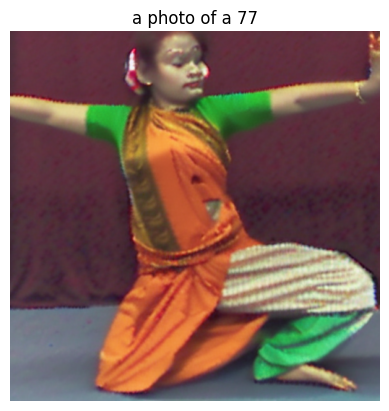

Saved image to: generated_image_77.png

--- Generating for prompt: 'a photo of a 79' ---


  0%|          | 0/40 [00:00<?, ?it/s]

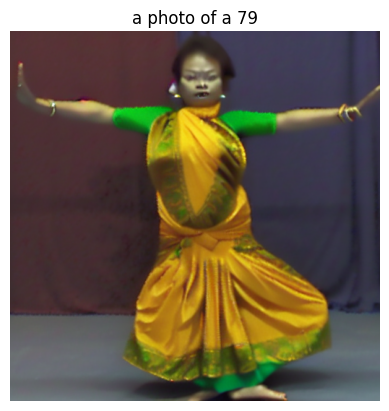

Saved image to: generated_image_79.png

--- Generating for prompt: 'a photo of a 8' ---


  0%|          | 0/40 [00:00<?, ?it/s]

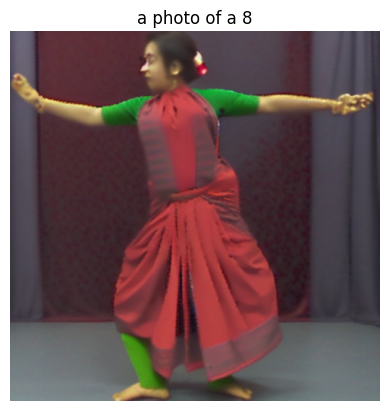

Saved image to: generated_image_8.png

--- Generating for prompt: 'a photo of a 85' ---


  0%|          | 0/40 [00:00<?, ?it/s]

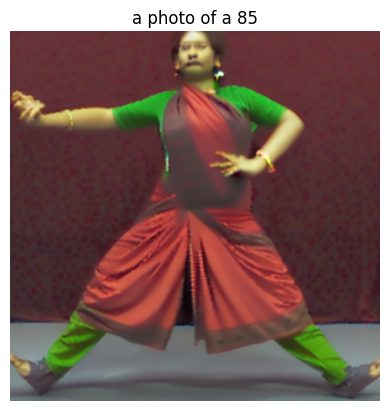

Saved image to: generated_image_85.png

--- Generating for prompt: 'a photo of a 87' ---


  0%|          | 0/40 [00:00<?, ?it/s]

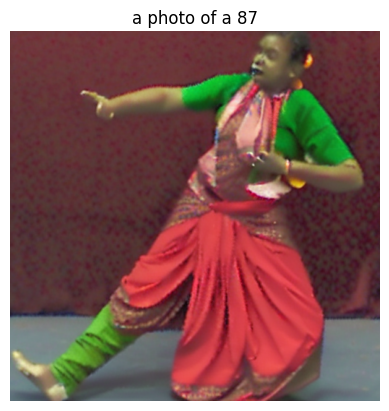

Saved image to: generated_image_87.png

 All images generated!


In [5]:
import matplotlib.pyplot as plt

# TODO: Fill this list with the names of all 20 of your folders
# I've added the two you mentioned as an example.
FOLDER_NAMES = [
    "100", 
    "103",
    "11", 
    "153",
    "27",
    "3",
    "44",
    "45",
    "46",
    "47",
    "48",
    "49",
    "5",
    "59",
    "60",
    "77",
    "79",
    "8",
    "85",
    "87"
]

print(f"Generating {len(FOLDER_NAMES)} images...")

# --- Loop through every folder name ---
for name in FOLDER_NAMES:
    # 1. Create the prompt (cleaning up the name just like in training)
    prompt = f"a photo of a {name.replace('_', ' ')}"
    
    print(f"\n--- Generating for prompt: '{prompt}' ---")
    
    # 2. Run the generation
    image = pipe(prompt, num_inference_steps=40, guidance_scale=7.5).images[0]
    
    # 3. Display the image
    plt.figure()
    plt.title(prompt)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    # 4. Save the image with a unique name
    save_name = f"generated_image_{name}.png"
    image.save(save_name)
    print(f"Saved image to: {save_name}")

print("\n All images generated!")